## Gaussian Process Regression wit GPy

In [27]:
import numpy as np
import pandas as pd

### 1. Read the data

In [28]:
all_positions = pd.read_csv('../test-data/positions_xyz_2024-02-27_13h38m.csv', delimiter=',')
all_positions

,x,y,z
0,7.140000,3.070000,15
1,7.140000,3.070000,15
2,7.140000,3.070000,15
3,7.140000,3.070000,15
4,7.156666,3.169981,15
...,...,...,...
1473,2.227737,0.208745,15
1474,2.230873,0.240388,15
1475,2.234063,0.275175,15
1476,2.237308,0.313067,15


In [29]:
all_red_ball_positions = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',')

all_red_ball_positions

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,0.0,42.0,87.0,39.0,NaN,NaN,44.0,83.0,89.0,83.0,NaN,NaN,69.0,122.0
1,0.5,42.5,87.0,40.0,NaN,NaN,45.0,84.0,89.0,84.0,NaN,NaN,68.5,120.5
2,0.5,43.5,87.0,41.0,NaN,NaN,45.0,85.0,89.0,85.0,NaN,NaN,68.5,120.5
3,1.0,45.0,87.5,42.0,NaN,NaN,45.0,86.0,89.0,86.0,NaN,NaN,68.5,120.5
4,1.0,45.5,88.0,43.0,NaN,NaN,45.0,86.0,90.0,87.0,NaN,NaN,68.5,120.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.0,59.0,111.0,59.0,59.5,69.0,54.5,105.0,68.0,118.5
497,67.0,9.0,55.0,26.0,63.0,58.0,110.0,58.0,59.5,69.0,54.0,103.0,68.0,118.5
498,66.0,8.0,55.0,26.0,62.0,57.0,109.0,57.0,59.5,69.0,53.0,102.5,68.0,118.5
499,65.0,5.0,55.0,26.0,61.0,55.0,107.5,55.0,59.5,69.0,52.0,101.0,68.0,118.5


In [30]:
all_positions = all_positions.iloc[4:]
all_positions.reset_index(drop=True, inplace=True)
all_red_ball_positions.shape,  all_positions.shape

((501, 14), (1474, 3))

In [31]:
# Assuming all_red_ball_positions and all_positions are your DataFrames
combined_data = pd.concat([all_red_ball_positions, all_positions], axis=1)

# Remove all rows with 6 or more missing values not with thresh
#combined_data = combined_data.dropna(thresh=combined_data.shape[1]-7)
combined_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,0.0,42.0,87.0,39.0,NaN,NaN,44.0,83.0,89.0,83.0,NaN,NaN,69.0,122.0,7.156666,3.169981,15
1,0.5,42.5,87.0,40.0,NaN,NaN,45.0,84.0,89.0,84.0,NaN,NaN,68.5,120.5,7.173333,3.269852,15
2,0.5,43.5,87.0,41.0,NaN,NaN,45.0,85.0,89.0,85.0,NaN,NaN,68.5,120.5,7.189999,3.369500,15
3,1.0,45.0,87.5,42.0,NaN,NaN,45.0,86.0,89.0,86.0,NaN,NaN,68.5,120.5,7.206665,3.468816,15
4,1.0,45.5,88.0,43.0,NaN,NaN,45.0,86.0,90.0,87.0,NaN,NaN,68.5,120.5,7.223330,3.567688,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.227737,0.208745,15
1470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.230873,0.240388,15
1471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.234063,0.275175,15
1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.237308,0.313067,15


In [32]:
all_red_ball_positions = combined_data.iloc[:, :14]
all_positions = combined_data.iloc[:, 14:]
all_red_ball_positions.shape, all_positions.shape

((1474, 14), (1474, 3))

### 2. Handle Missing Values

In [33]:
from sklearn.impute import SimpleImputer, KNNImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_knn = KNNImputer(n_neighbors=2)
X_all = imputer_knn.fit_transform(all_red_ball_positions)
y_all = imputer_knn.fit_transform(all_positions)
X_all.shape, y_all.shape

((1474, 14), (1474, 3))

### 3. Prepare the Data

In [34]:
total_samples = len(X_all)
train_samples = int(0.8 * total_samples)

# Split the data
X_train = X_all[:train_samples]
y_train = y_all[:train_samples]

X_test = X_all[train_samples:]
y_test = y_all[train_samples:]

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1179, 14), (295, 14), (1179, 3), (295, 3))

In [36]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled_train = scaler_x.fit_transform(X_train)
y_scaled_train = y_train

### 4. Train the Model

In [37]:
from GPy.kern import RBF
from GPy.models import GPRegression

#### 4.1 Train GP Regression Model with GPy
For normal regression tasks

In [38]:
kernel = RBF(input_dim=14)
model = GPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model.optimize(messages=True)

In [39]:
model

GP_regression.,value,constraints,priors
rbf.variance,83.15911132099055,+ve,
rbf.lengthscale,16.322967501157194,+ve,
Gaussian_noise.variance,2.6593578227535164,+ve,


#### 4.2 Train Sparse GP Regression Model with GPy
Model for large datasets

In [40]:
from GPy.models import SparseGPRegression

kernel = RBF(input_dim=14)
model_sparse = SparseGPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model_sparse.optimize(messages=True)

In [41]:
model_sparse

sparse_gp.,value,constraints,priors
inducing inputs,"(10, 14)",,
rbf.variance,64.80620092959074,+ve,
rbf.lengthscale,23.35193841346801,+ve,
Gaussian_noise.variance,2.7148293387796216,+ve,


### 5. Make Predictions

In [42]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_scaled_test = scaler_x.transform(X_test)

#### 5.1 Predict with GP Regression Model

In [43]:
y_pred_reg, y_var_reg = model.predict(X_scaled_test)
y_pred_reg = y_pred_reg
y_pred_reg

array([[ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.01581153],
       [ 8.53503497,  3.01742938, 15.015

#### 5.2 Predict with Sparse GP Regression Model

In [44]:
y_pred_sparse, y_var_sparse = model_sparse.predict(X_scaled_test)
y_var_sparse

array([[2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.71976718],
       [2.719

### 6. Evaluate the Model

In [45]:
def evaluate_model(y_test_evaluate, y_pred_evaluate):
    mse = mean_squared_error(y_test_evaluate, y_pred_evaluate)
    r2 = r2_score(y_test_evaluate, y_pred_evaluate)
    mae = mean_absolute_error(y_test_evaluate, y_pred_evaluate)
    return mse, r2, mae


#### 6.1 Evaluate GP Regression Model

In [46]:
y_test

array([[ 3.582112  ,  6.063967  , 15.        ],
       [ 3.570422  ,  6.055967  , 15.        ],
       [ 3.558771  ,  6.044649  , 15.        ],
       [ 3.547161  ,  6.030027  , 15.        ],
       [ 3.53559   ,  6.012116  , 15.        ],
       [ 3.524058  ,  5.990934  , 15.        ],
       [ 3.512568  ,  5.966509  , 15.        ],
       [ 3.501117  ,  5.938866  , 15.        ],
       [ 3.489707  ,  5.908035  , 15.        ],
       [ 3.478338  ,  5.874052  , 15.        ],
       [ 3.467009  ,  5.836954  , 15.        ],
       [ 3.455722  ,  5.796782  , 15.        ],
       [ 3.444475  ,  5.75358   , 15.        ],
       [ 3.433267  ,  5.707391  , 15.        ],
       [ 3.422103  ,  5.658278  , 15.        ],
       [ 3.41098   ,  5.606288  , 15.        ],
       [ 3.399898  ,  5.551481  , 15.        ],
       [ 3.388858  ,  5.493917  , 15.        ],
       [ 3.377859  ,  5.433661  , 15.        ],
       [ 3.366902  ,  5.370778  , 15.        ],
       [ 3.355986  ,  5.305332  , 15.   

In [47]:
mse_reg, r2_reg, mae_reg = evaluate_model(y_test, y_pred_reg)
print("MSE:", mse_reg)
print("R2:", r2_reg)
print("MAE:", mae_reg)

MSE: 13.596917075653955
R2: -64.88917501104028
MAE: 2.6533769745765095


#### 6.2 Evaluate Sparse GP Regression Model

In [48]:
mse_sparse, r2_sparse, mae_sparse = evaluate_model(y_test, y_pred_sparse)
print("MSE:", mse_sparse)
print("R2:", r2_sparse)
print("MAE:", mae_sparse)

MSE: 13.97576402664045
R2: -66.93288914069093
MAE: 2.689294029763809


### 7. Visualize results

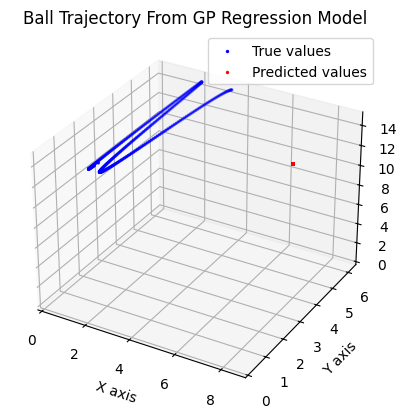

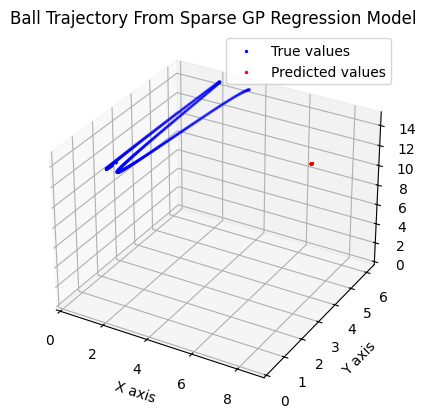

In [49]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(y_test, y_pred_reg, "Ball Trajectory From GP Regression Model")
plot_maker_3d(y_test, y_pred_sparse, "Ball Trajectory From Sparse GP Regression Model")

In [50]:
from utils.plot_maker_gaussian_process import gaussian_process_plot

In [51]:
y_var_reg

array([[2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.66320485],
       [2.663

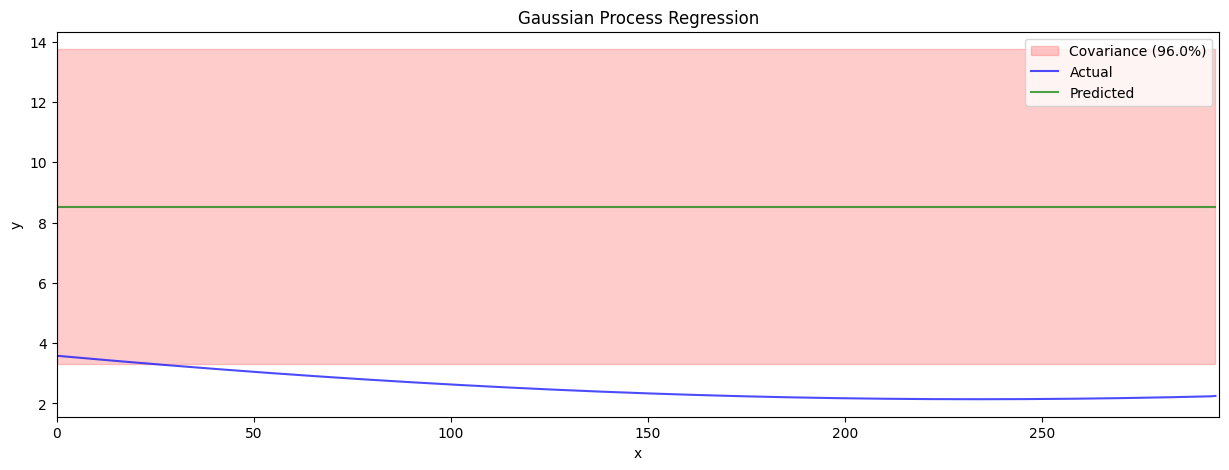

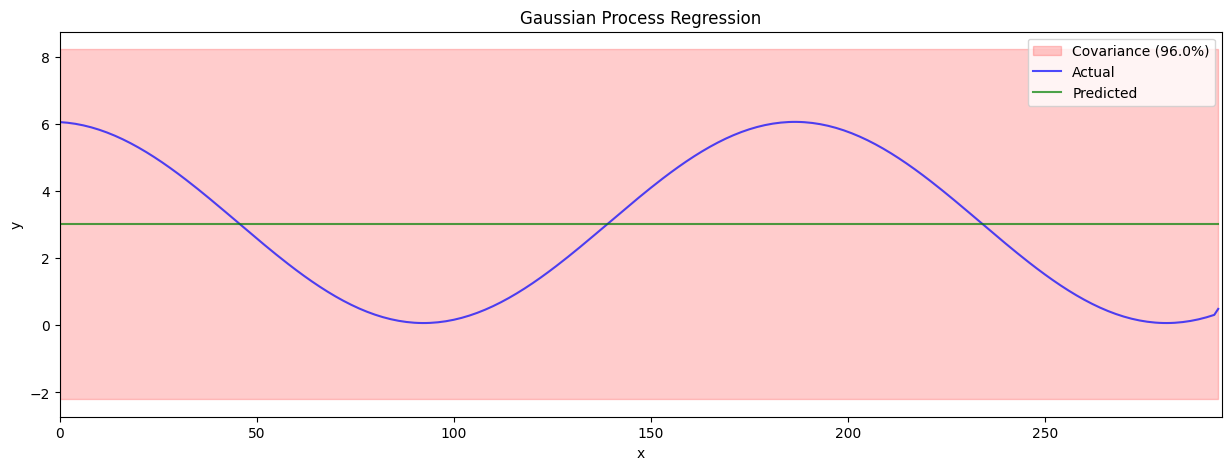

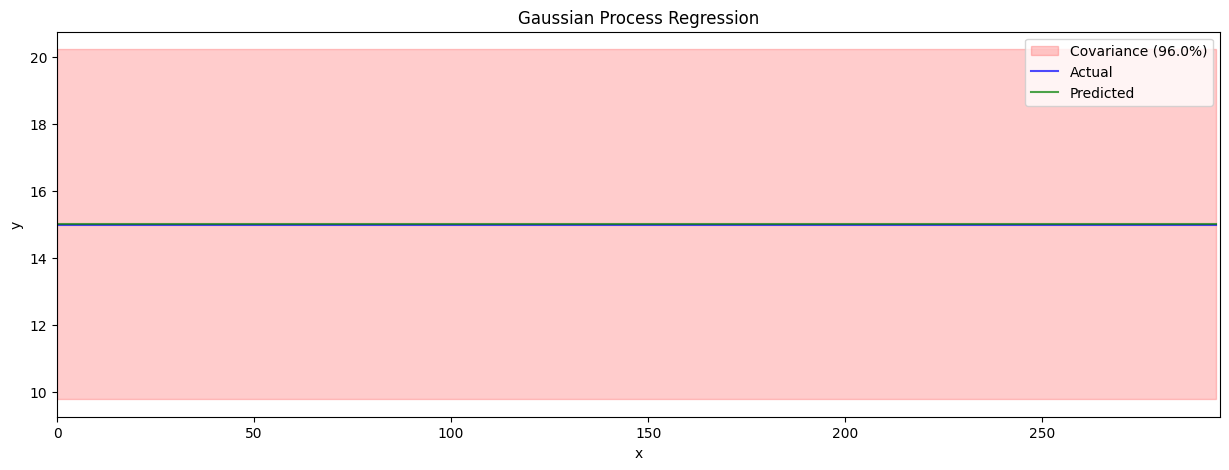

In [52]:
y_pred_reg = np.array(y_pred_reg)
y_test = np.array(y_test)
y_var_reg = np.array(y_var_reg)
y_var_reg = np.mean(y_var_reg, axis=1)

y_pred_x, y_pred_y, y_pred_z = y_pred_reg[:, 0], y_pred_reg[:, 1], y_pred_reg[:, 2]
y_test_x, y_test_y, y_test_z = y_test[:, 0], y_test[:, 1], y_test[:, 2]

gaussian_process_plot(y_test_x, y_pred_x, y_var_reg)
gaussian_process_plot(y_test_y, y_pred_y, y_var_reg)
gaussian_process_plot(y_test_z, y_pred_z, y_var_reg)